# How to Access and Analyze GPM Data from the S3 Giovanni Cache Zarr Store

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook demonstrates how to access the Giovanni Cache Zarr Store [S3 bucket](https://disc.gsfc.nasa.gov/information/faqs?keywords=%22earthdata%20cloud%22&title=What%20is%20S3%20access%3F) inside the [AWS us-west-2](https://disc.gsfc.nasa.gov/information/documents?title=Migrating%20to%20the%20Cloud) region for performing analysis. It accesses the [GPM IMERG Final Precipitation L3 Half Hourly 0.1 degree x 0.1 degree V06 precipitationCal](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_06/summary?keywords=GPM_3IMERGHH_06) variable Zarr Store, then subsets it over the Galapagos Islands (using the following bounding box: `[-91.6963, -1.4307, -89.212, 0.6514]`) over the 2014-2017 temporal range. Finally, it compares and plots monthly average precipitation and the [MEI v2 ENSO Index](https://psl.noaa.gov/enso/mei/), provided by NOAA.

<img src="https://raw.githubusercontent.com/nasa/gesdisc-tutorials/feature/giovanni-zarr-cache/images/Galapagos_Analysis_Area.png" alt="Galapagos Analysis Area" width="425">
<img src="https://raw.githubusercontent.com/nasa/gesdisc-tutorials/feature/giovanni-zarr-cache/images/Galapagos_Penguins.png" alt="Galapagos Penguins" width="425">

### Prerequisites

This notebook was written using Python 3.9, and requires these libraries and files: 
- netrc file with valid Earthdata Login credentials.
  - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Xarray
- requests
- S3FS
- Boto3
- NumPy
- Matplotlib
- Seaborn
- Pandas



### Import Libraries

In [1]:
import s3fs
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

### Read in Zarr store with temporary credentials and xarray

In [2]:
def retrieve_credentials():
    """Makes the Oauth calls to authenticate with EDS and return a set of s3 same-region, read-only credentials."""
    response = requests.get("https://api.giovanni.earthdata.nasa.gov/s3credentials")
    response.raise_for_status()
    return response.json()

In [3]:
def get_zarr_store():
    """Create an S3ZarrStore for the GPM_3IMERGHH_06_precipitationCal variable."""
    creds = retrieve_credentials()
    bucket_name = "prod-giovanni-cache"
    bucket_path = "zarr/GPM_3IMERGHH_06_precipitationCal"

    s3 = s3fs.S3FileSystem(key=creds["AccessKeyId"], 
                           secret=creds["SecretAccessKey"], 
                           token=creds["SessionToken"])

    store = s3.get_mapper(f"{bucket_name}/{bucket_path}")
    return store

In [4]:
store = get_zarr_store()

### Open Zarr Store using Xarray

In [5]:
%%time
data = xr.open_zarr(store=store, consolidated=False)

CPU times: user 4.57 s, sys: 195 ms, total: 4.77 s
Wall time: 13.3 s


In [6]:
data

<xarray.Dataset>
Dimensions:      (latitude: 1800, longitude: 3600, time: 374200, bounds: 2)
Coordinates:
  * latitude     (latitude) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * longitude    (longitude) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * time         (time) datetime64[s] 2000-06-01 ... 2000-05-31T23:00:00
Dimensions without coordinates: bounds
Data variables:
    time_bounds  (time, bounds) datetime64[s] dask.array<chunksize=(200, 2), meta=np.ndarray>
    variable     (latitude, longitude, time) float32 dask.array<chunksize=(36, 72, 200), meta=np.ndarray>

Mask and drop where there are fill values (numpy.datetime64('2000-05-31T23:00:00'))

In [7]:

data_masked_dropped = data.where(data["time"] != data["time"]._FillValue, drop=True)

In [8]:
data_masked_dropped

<xarray.Dataset>
Dimensions:      (time: 374016, bounds: 2, latitude: 1800, longitude: 3600)
Coordinates:
  * latitude     (latitude) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * longitude    (longitude) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * time         (time) datetime64[s] 2000-06-01 ... 2021-09-30T23:30:00
Dimensions without coordinates: bounds
Data variables:
    time_bounds  (time, bounds) datetime64[s] dask.array<chunksize=(200, 2), meta=np.ndarray>
    variable     (latitude, longitude, time) float32 dask.array<chunksize=(36, 72, 200), meta=np.ndarray>

## Define a time range and a bounding box covering the Galapagos Islands

In [9]:
var_name = "variable" 
start_time = "2014-01-01T00:00:00" 
end_time = "2017-12-31T23:30:00" 
time_slice = slice(start_time, end_time) 
start_year = int(start_time.split("-")[0])
end_year = int(end_time.split("-")[0]) + 1

bbox = [-91.6963, -1.4307, -89.212, 0.6514] 
lon_slice = slice(bbox[0], bbox[2]) 
lat_slice = slice(bbox[1], bbox[3])

In [10]:
data_subset = data_masked_dropped.sel( 
    time=time_slice, 
    latitude=lat_slice, 
    longitude=lon_slice, 
)

In [11]:
data_subset

<xarray.Dataset>
Dimensions:      (time: 70128, bounds: 2, latitude: 21, longitude: 25)
Coordinates:
  * latitude     (latitude) float32 -1.35 -1.25 -1.15 -1.05 ... 0.45 0.55 0.65
  * longitude    (longitude) float32 -91.65 -91.55 -91.45 ... -89.35 -89.25
  * time         (time) datetime64[s] 2014-01-01 ... 2017-12-31T23:30:00
Dimensions without coordinates: bounds
Data variables:
    time_bounds  (time, bounds) datetime64[s] dask.array<chunksize=(24, 2), meta=np.ndarray>
    variable     (latitude, longitude, time) float32 dask.array<chunksize=(14, 25, 24), meta=np.ndarray>

## Calculate the monthly averages and the weighted area-averaged time series

In [12]:
def average_time_series(data, var_name):
    """Calculate the monthly averages and weighted area-averaged time series."""
    # Calculate monthly average
    data_monthly_avg = data.resample(time="1M").mean()
    
    # Calculate the weights
    lat_weights = np.cos(np.pi*data_monthly_avg.latitude/180.0)

    # Project the weights onto an array that is the same shape as the subset
    lat_weights = np.logical_not(np.isnan(data_monthly_avg[var_name]))*lat_weights

    # Calculate the average
    data_avg = (lat_weights * data_monthly_avg[var_name]).sum(dim=("latitude","longitude"))/lat_weights.sum(dim=("latitude","longitude"))
    
    return data_avg

In [13]:
data_avg = average_time_series(data_subset, var_name)

In [14]:
data_avg

<xarray.DataArray (time: 48)>
dask.array<truediv, shape=(48,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-01-31 2014-02-28 ... 2017-12-31

## Read in ENSO Index data

In [15]:
# Multivariate ENSO Index Version 2 (MEI.v2) to plot against precipitation data
with open("meiv2.data") as f:
    mei_data = f.readlines()
    
mei_data_df = pd.DataFrame([np.array(line.strip().split()).astype(float) for line in mei_data]).set_index(0).T
enso_index = mei_data_df.loc[:, f"{start_year}":f"{end_year}"].T.stack().values

# Monthly average ENSO over the year range
avg_enso = enso_index.reshape(-1, 12).mean(axis=0)

## Plot the time series

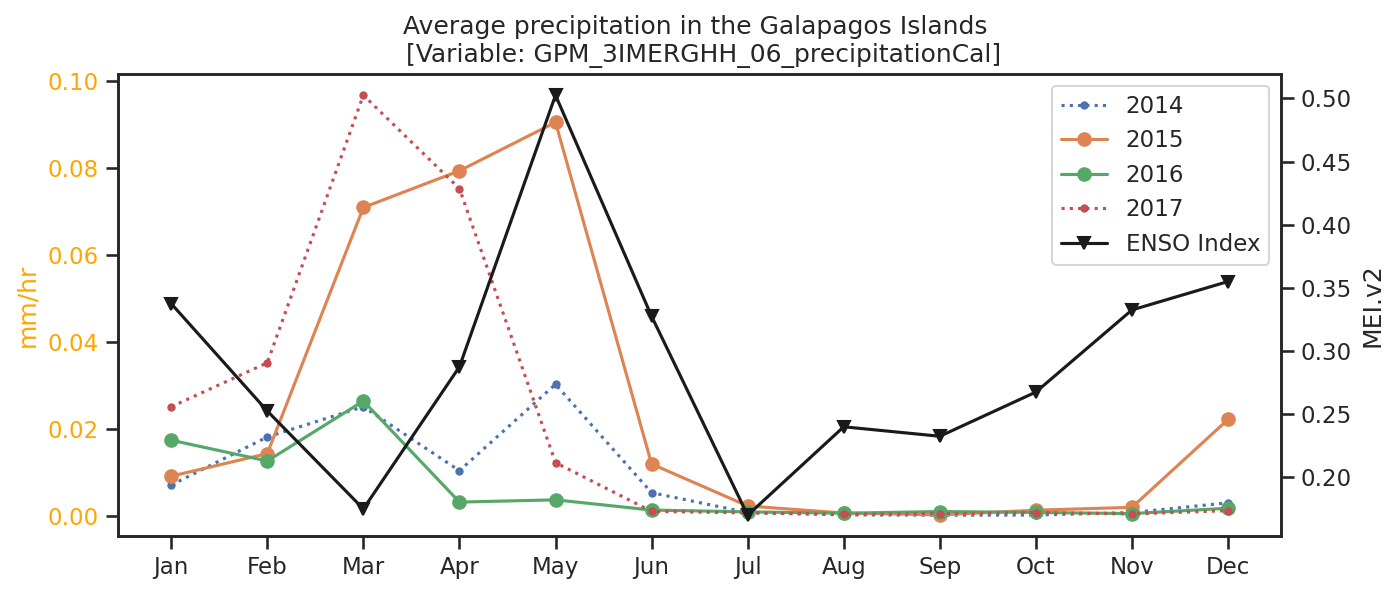

CPU times: user 1min 6s, sys: 5.41 s, total: 1min 12s
Wall time: 1min 28s


In [16]:
%%time
fig, ax1 = plt.subplots(figsize=(10,4), dpi=150)

month_ticks = range(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for year in range(start_year, end_year):
    year_data = data_avg.loc[f"{year}-01-01":f"{year}-12-31"]
    if year == 2015 or year == 2016:
        ax1.plot(year_data.time.dt.month, year_data.values, label=year, marker="o")
    else:
        ax1.plot(year_data.time.dt.month, year_data.values, label=year, linestyle=":", marker=".")
        
ax1.set_ylabel("mm/hr", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")
        
ax2 = ax1.twinx()
ax2.plot(year_data.time.dt.month, avg_enso, label="ENSO Index", c="k", marker="v")
ax2.set_ylabel("MEI.v2") 

handles, labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles,labels)

plt.title("Average precipitation in the Galapagos Islands \n [Variable: GPM_3IMERGHH_06_precipitationCal]")
plt.xlabel("Time (UTC)")
plt.xticks(month_ticks, month_labels)
plt.show()

# Acknowledgments

Openscapes for providing Jupyter Hub access, Jim Acker for coming up with the scenario, Christine Smit for the area averaging function, Faith Giguere for the method to get temporary AWS credentials, and the Cloud Giovanni team for contributing to this epic.